# Lista 08 - Regras de Associação

>Yanna Torres Gonçalves
>
>Matrícula: 587299
>
>Mestrado em Ciências da Computação

In [ ]:
!pip install spacy emoji pandas numpy mlxtend matplotlib seaborn networkx
!python -m spacy download pt_core_news_sm

In [2]:
from tqdm import tqdm
tqdm.pandas()

## Carregamento dos Dados e Tratamento

In [3]:
import emoji
import re

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

In [4]:
import pandas as pd

data_url = "https://media.githubusercontent.com/media/yanna-torres/CKP9011-ciencia-de-dados/refs/heads/lista-01/data/fakeTelegram.BR_2022.csv"

df = pd.read_csv(data_url)

In [5]:
df.columns

Index(['date_message', 'id_member_anonymous', 'id_group_anonymous', 'media',
       'media_type', 'media_url', 'has_media', 'has_media_url', 'trava_zap',
       'text_content_anonymous', 'dataset_info_id', 'date_system',
       'score_sentiment', 'score_misinformation', 'id_message', 'message_type',
       'messenger', 'media_name', 'media_md5'],
      dtype='object')

In [6]:
len(df)

557586

In [7]:
def has_trava_zap(message):
    if not isinstance(message, str):
        return False  # Garante que só analisa strings

    # Regra 1: muito longo
    if len(message) > 10000:
        return True

    # Regra 2: caracteres invisíveis
    invisible = ''.join(chr(c) for c in range(0x200B, 0x200F + 1)) + '\uFEFF'
    if sum(message.count(c) for c in invisible) > 100:
        return True

    # Regra 3: emojis repetidos
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                              "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
    emojis = emoji_pattern.findall(message)
    if any(len(e) > 20 for e in emojis):
        return True

    # Regra 4: baixa diversidade
    unique = set(message)
    if len(unique) < 10 and len(message) > 500:
        return True

    return False

In [8]:
df['trava_zap'] = df['text_content_anonymous'].progress_apply(has_trava_zap)
df_clean = df[df['trava_zap'] == False]
df_clean.drop(columns=['trava_zap'], inplace=True)

100%|██████████| 557586/557586 [00:05<00:00, 96663.71it/s] 
/tmp/ipykernel_317/3730847118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=['trava_zap'], inplace=True)


In [9]:
spam_keywords = [
    "clique aqui", "click here", "compre agora", "buy now", "grátis", 
    "free", "promoção", "desconto", "💰", "$$$", "sorteado", "ganhou", 
    "aproveite", "inscreva-se", "subscribe", "oferta", "welcome", "bem-vindo", "bem-vinda", "bem vindo", "bem vinda",
    "última vaga", "feedback", "user", "investidor", "invest", "investir", "platform", "community was blocked", "sex",
    "rough", "anal", "vaginall", "vaginal", "🙈", "😱", "👩‍❤‍👩", "congratulations", "trading", "alexeconomia", "crypto",
    "Milda Suely Del Grecco", "Maria Teresa D  Valente", "bitcoin", "rape"
]

In [10]:
def contains_spam_keywords(text):
    text_lower = text.lower()
    return any(keyword.lower() in text_lower for keyword in spam_keywords)

def is_too_short_or_long(text):
    return len(text) < 5 or len(text) > 500

def has_spammy_chars(text):
    return bool(re.search(r"[!]{3,}|[$]{2,}|[💰🔥🎁✅]", text))

# 4. Função principal
def is_spam(text):
    if pd.isnull(text):
        return True
    return (
        contains_spam_keywords(text)
        or is_too_short_or_long(text)
        or has_spammy_chars(text)
    )

In [11]:
df_clean["is_spam"] = df_clean["text_content_anonymous"].progress_apply(is_spam)
df_clean = df_clean[~df_clean["is_spam"]].drop(columns="is_spam").drop_duplicates()

100%|██████████| 556305/556305 [00:08<00:00, 69453.43it/s]
/tmp/ipykernel_317/298558259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["is_spam"] = df_clean["text_content_anonymous"].progress_apply(is_spam)


In [12]:
len(df_clean)

288479

---

In [13]:
df_clean = df_clean.drop(columns=['dataset_info_id',
       'date_system', 'score_sentiment', 'score_misinformation', 'id_message',
       'message_type', 'messenger', 'media_name', 'media_md5', 'date_message', 'id_member_anonymous',
       'id_group_anonymous', 'media', 'media_type', 'media_url', 'has_media',
       'has_media_url',
])

In [14]:
df_clean['text_wo_emoji'] = df_clean['text_content_anonymous'].progress_apply(remove_emojis)

100%|██████████| 288479/288479 [00:20<00:00, 14378.51it/s]


In [15]:
import spacy

nlp = spacy.load("pt_core_news_sm") 

In [16]:
messages = df_clean['text_wo_emoji'].tolist()

entities_messages = []

In [17]:
for doc in tqdm(nlp.pipe(messages, batch_size=32), total=len(messages), desc="Processing messages"):
    entities = list(set(ent.text for ent in doc.ents))
    entities_messages.append(entities)

Processing messages: 100%|██████████| 288479/288479 [09:43<00:00, 494.54it/s] 


In [18]:
entities_messages[:5]

[['Fato Renato', 'Fonseca', 'Niterói'],
 ['YouTube'],
 ['Universo'],
 ['GENTE ACHEI'],
 ['Kķkkkkk', 'Bolsonaro']]

## Associação

In [19]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

te = TransactionEncoder()
te_ary = te.fit(entities_messages).transform(entities_messages)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

### Apriori

In [20]:
apriori_frequencies = apriori(df_transactions, min_support=0.001, use_colnames=True)

In [21]:
apriori_rules = association_rules(apriori_frequencies, metric="lift", min_threshold=0.02)
apriori_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(After that),(REVEAL),0.001664,1.000000,599.748441
1,(REVEAL),(After that),0.001664,0.997921,599.748441
2,(After that),(THE TIME HAS COME! \n \nYou only have a few h...,0.001664,1.000000,600.997917
3,(THE TIME HAS COME! \n \nYou only have a few h...,(After that),0.001664,1.000000,600.997917
4,(Take),(After that),0.001664,0.975610,586.339431
...,...,...,...,...,...
173095,(REVEAL),"(it goes private!, only those who, Take, After...",0.001664,0.997921,599.748441
173096,(the shadows),"(it goes private!, only those who, Take, After...",0.001664,1.000000,600.997917
173097,(They intended to eliminate),"(it goes private!, only those who, Take, After...",0.001664,1.000000,600.997917
173098,(They wish to destroy what they are unable to ...,"(it goes private!, only those who, Take, After...",0.001664,1.000000,600.997917


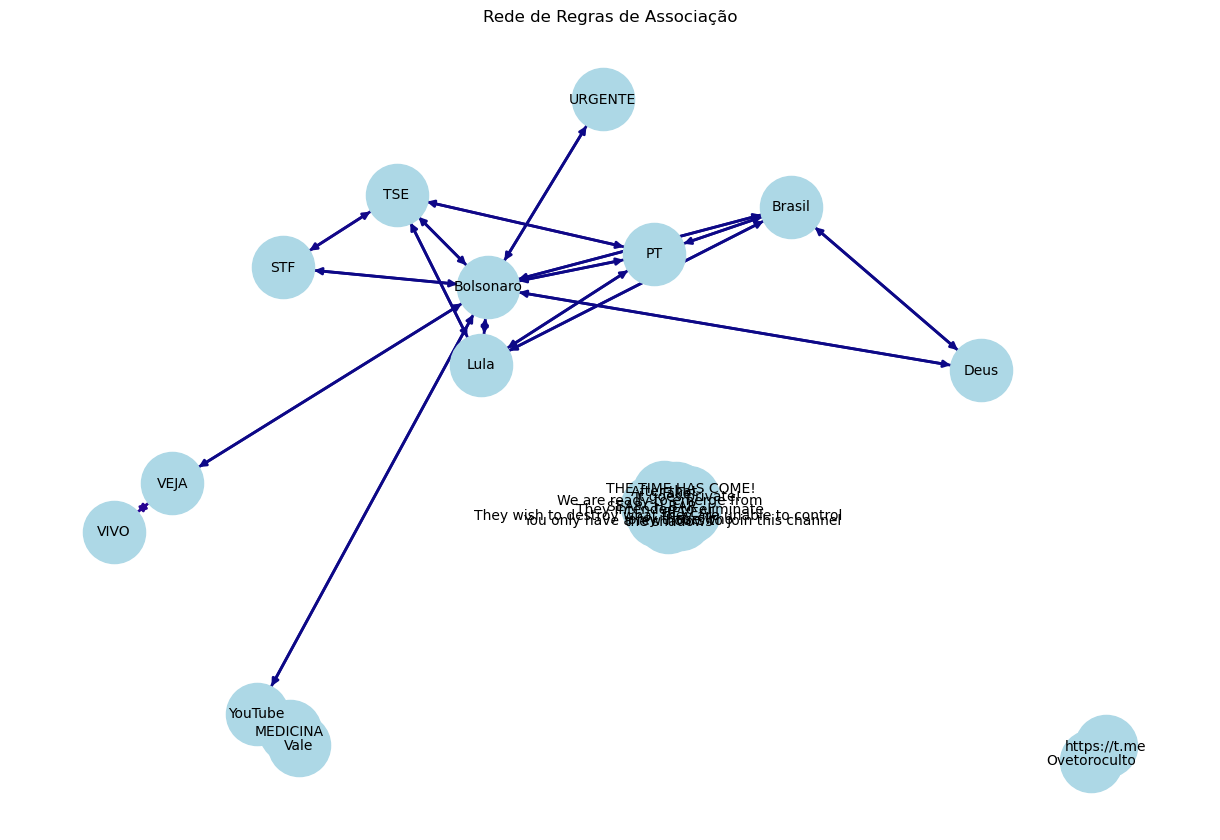

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for _, row in apriori_rules.iterrows():
    for ant in row['antecedents']:
        for cons in row['consequents']:
            G.add_edge(ant, cons, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1.2)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, with_labels=True, edge_color=weights, width=2.0,
        edge_cmap=plt.cm.plasma, node_size=2000, font_size=10, node_color='lightblue')
plt.title("Rede de Regras de Associação")
plt.show()

### ECLAT (Equivalence Class Clustering and bottom-up Lattice Traversal)

In [24]:
from collections import defaultdict
from itertools import combinations

item_tid = defaultdict(set)

for i, transaction in enumerate(entities_messages):
    for item in transaction:
        item_tid[item].add(i)

In [29]:
min_support_count = int(0.001 * len(entities_messages))
eclat_rules = []

for item1, item2 in tqdm(combinations(item_tid, 2), total=(len(item_tid) * (len(item_tid) - 1)) // 2, desc="Generating ECLAT rules"):
    intersection = item_tid[item1] & item_tid[item2]
    if len(intersection) >= min_support_count:
        eclat_rules.append(((item1,), (item2,), len(intersection) / len(entities_messages)))

Generating ECLAT rules: 100%|██████████| 5793561546/5793561546 [1:09:37<00:00, 1386879.34it/s]


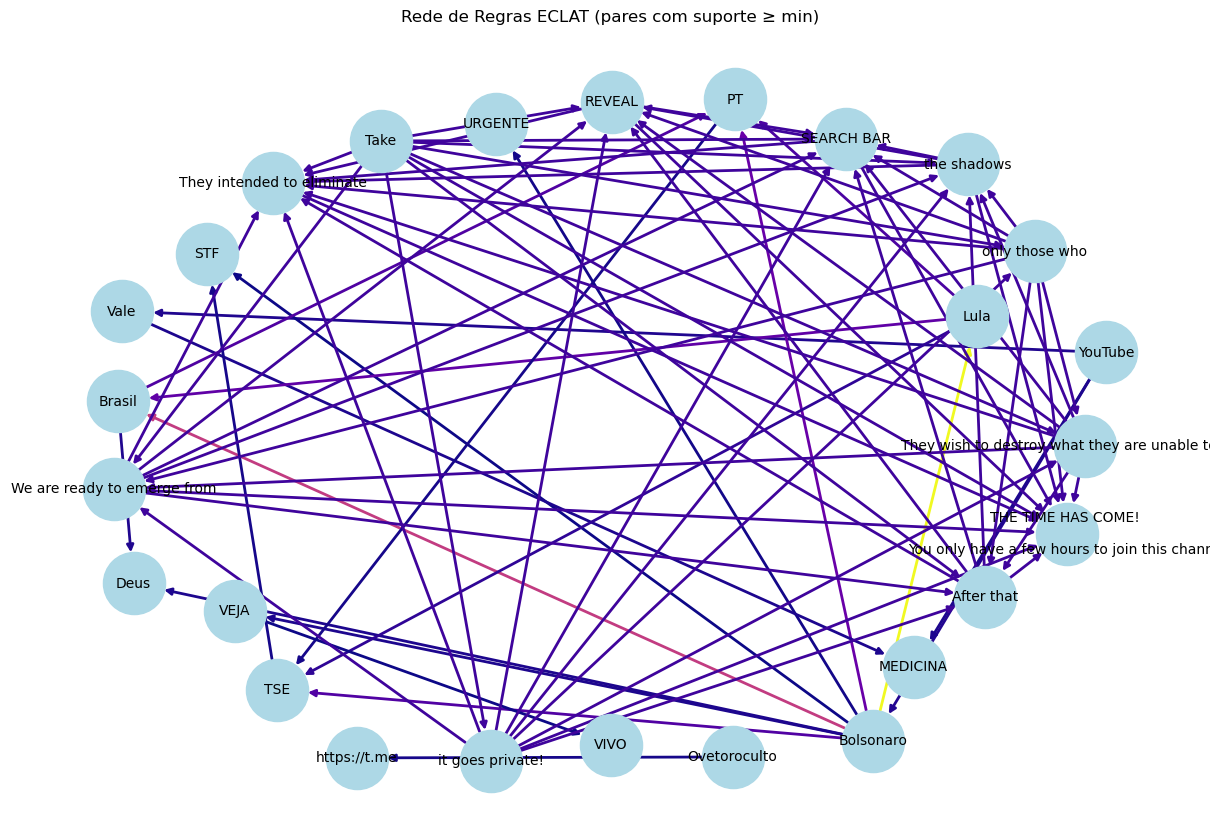

In [31]:
G = nx.DiGraph()

for ant, cons, support in eclat_rules:
    G.add_edge(ant[0], cons[0], weight=support)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1.5)
edges = G.edges()
weights = [G[u][v]['weight'] * 10 for u, v in edges]

nx.draw(G, pos, with_labels=True, edge_color=weights, width=2.0,
        edge_cmap=plt.cm.plasma, node_size=2000, font_size=10, node_color='lightblue')
plt.title("Rede de Regras ECLAT (pares com suporte ≥ min)")
plt.show()


### FP-Growth (Frequent Pattern Growth)

In [ ]:
from mlxtend.frequent_patterns import fpgrowth

fpgrowth_frequencies = fpgrowth(df_transactions, min_support=0.001, use_colnames=True)
fpgrowth_rules = association_rules(fpgrowth_frequencies, metric="lift", min_threshold=1.0)

In [ ]:
fpgrowth_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

In [ ]:
G = nx.DiGraph()

for _, row in fpgrowth_rules.iterrows():
    for ant in row['antecedents']:
        for cons in row['consequents']:
            G.add_edge(ant, cons, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1.2)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, with_labels=True, edge_color=weights, width=2.0,
        edge_cmap=plt.cm.plasma, node_size=2000, font_size=10, node_color='lightblue')
plt.title("Rede de Regras de Associação")
plt.show()